# Análisis de caudal frío/caliente

Notebook reproducible para procesar lecturas de un grifo con dos canales (frío y caliente).

**Requisitos**: `pandas`, `numpy`, `matplotlib`, `openpyxl`. Instalar con:

```bash
pip install pandas numpy matplotlib
```

**Entradas esperadas**: archivo Excel con columnas en este orden:
`toma | fecha | hora | agua fría | agua caliente`.

**Salidas**:
- `eventos_caudal.csv` – tabla de eventos con métricas por apertura.
- `resumen_caudal.json` – indicadores globales.
- Gráficas PNG opcionales.


## 1) Imports y parámetros

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path

# Crear directorio 'resultados' si no existe
output_dir = Path("resultados")
output_dir.mkdir(exist_ok=True)

print("Directorio de salida:", output_dir.resolve())
# === Parámetros ===
FILE_IN = 'Datos_caudalimetros.xlsx' 
THRESHOLD_LPM = 0.3                    # Umbral para detectar apertura (L/min)
EXPORT_EVENTOS = output_dir / 'eventos_caudal.csv'
EXPORT_RESUMEN =  output_dir / 'resumen_caudal.json'


print('Usando archivo:', FILE_IN)
print('Umbral L/min   :', THRESHOLD_LPM)


Directorio de salida: /Users/albamagdaleno/Desktop/tfg-git/TFG_waterflow/resultados
Usando archivo: Datos_caudalimetros.xlsx
Umbral L/min   : 0.3


## 2) Carga y preprocesado

In [2]:
# Cargar Excel
df = pd.read_excel(FILE_IN)
# Asumimos columnas: nº de toma | fecha | hora | agua fría | agua caliente
df.columns = ['toma', 'fecha', 'hora', 'agua_fria', 'agua_caliente']

# Timestamp a partir de fecha + hora
df['timestamp'] = pd.to_datetime(
    df['fecha'].astype(str) + ' ' + df['hora'].astype(str),
    dayfirst=True,
    errors='coerce'
)

df = df.sort_values('timestamp').reset_index(drop=True)

# Limpieza: numéricos, NaN->0, negativos->0
for col in ['agua_fria', 'agua_caliente']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).clip(lower=0)

# Caudal total
df['agua_total'] = df['agua_fria'] + df['agua_caliente']

# Vista previa
df.head()


,toma,fecha,hora,agua_fria,agua_caliente,timestamp,agua_total
0,1,21-07-2025,17:22,0.260,0.0,2025-07-21 17:22:00,0.260
1,2,21-07-2025,17:22,0.280,0.0,2025-07-21 17:22:00,0.280
2,3,21-07-2025,18:37,0.091,0.0,2025-07-21 18:37:00,0.091
3,4,21-07-2025,18:57,0.838,0.0,2025-07-21 18:57:00,0.838
4,5,21-07-2025,18:57,0.873,0.0,2025-07-21 18:57:00,0.873


## 3) Detección y segmentación de eventos

In [3]:
# Evento activo si el caudal total supera el umbral
df['activo'] = (df['agua_total'] > THRESHOLD_LPM).astype(int)

# Detectar inicios de evento cuando 'activo' pasa de 0 -> 1
cambios = df['activo'].diff().fillna(0)
evento_id = (cambios == 1).cumsum()
df['evento_id'] = np.where(df['activo'] == 1, evento_id, np.nan)

n_eventos_detectados = int(df['evento_id'].max()) if df['evento_id'].notna().any() else 0
print('Eventos detectados:', n_eventos_detectados)


Eventos detectados: 105


## 4) Métricas por evento

In [5]:
eventos = []
for eid, g in df.groupby('evento_id', dropna=True):
    g = g.sort_values('timestamp')
    t0 = g['timestamp'].iloc[0]
    tf = g['timestamp'].iloc[-1]
    dur_s = (tf - t0).total_seconds()
    mean_fria = g['agua_fria'].mean()
    mean_caliente = g['agua_caliente'].mean()
    mean_total = g['agua_total'].mean()
    vol_fria = mean_fria * dur_s / 60.0      # L = (L/min)*s/60
    vol_caliente = mean_caliente * dur_s / 60.0
    vol_total = vol_fria + vol_caliente
    prop_caliente = (100.0 * vol_caliente / vol_total) if vol_total > 0 else 0.0

    eventos.append({
        'ID': int(eid),
        'Inicio': t0,
        'Fin': tf,
        'Duración_s': round(dur_s, 3),
        'Caudal_medio_Lmin': round(mean_total, 3),
        'Caudal_pico_Lmin': round(g['agua_total'].max(), 3),
        'Volumen_frio_L': round(vol_fria, 3),
        'Volumen_caliente_L': round(vol_caliente, 3),
        'Volumen_total_L': round(vol_total, 3),
        'Proporcion_caliente_%': round(prop_caliente, 2),
    })

eventos_df = pd.DataFrame(eventos).sort_values('ID').reset_index(drop=True)
eventos_df.head(10)


,ID,Inicio,Fin,Duración_s,Caudal_medio_Lmin,Caudal_pico_Lmin,Volumen_frio_L,Volumen_caliente_L,Volumen_total_L,Proporcion_caliente_%
0,1,2025-07-21 18:57:00,2025-07-21 18:57:00,0.0,0.855,0.873,0.000,0.000,0.000,0.00
1,2,2025-07-21 18:59:00,2025-07-21 18:59:00,0.0,1375.000,1375.000,0.000,0.000,0.000,0.00
2,3,2025-07-21 19:03:00,2025-07-21 19:05:00,120.0,1867.250,3419.000,1261.000,2473.500,3734.500,66.23
3,4,2025-07-23 17:43:00,2025-07-23 19:50:00,7620.0,874.307,1389.000,82803.746,28233.264,111037.010,25.43
4,5,2025-07-28 11:29:00,2025-07-28 12:32:00,3780.0,612.938,2180.000,9464.580,29150.496,38615.076,75.49
5,6,2025-07-28 12:37:00,2025-07-28 19:54:00,26220.0,1.122,1.413,148.798,341.734,490.532,69.67
6,7,2025-07-28 19:54:00,2025-07-28 19:54:00,0.0,1103.959,1103.959,0.000,0.000,0.000,0.00
7,8,2025-07-28 19:55:00,2025-07-30 18:01:00,165960.0,1205.910,1336.053,712271.554,2623274.400,3335545.954,78.65
8,9,2025-07-30 18:01:00,2025-07-30 18:01:00,0.0,5900.000,5900.000,0.000,0.000,0.000,0.00
9,10,2025-07-30 18:05:00,2025-07-30 18:05:00,0.0,0.463,0.475,0.000,0.000,0.000,0.00


## 5) Resumen global y exportaciones

In [6]:
resumen = {
    'n_eventos': int(len(eventos_df)),
    'volumen_total_frio_L': round(float(eventos_df['Volumen_frio_L'].sum()), 3) if len(eventos_df) else 0.0,
    'volumen_total_caliente_L': round(float(eventos_df['Volumen_caliente_L'].sum()), 3) if len(eventos_df) else 0.0,
    'volumen_total_L': round(float(eventos_df['Volumen_total_L'].sum()), 3) if len(eventos_df) else 0.0,
    'caudal_medio_global_Lmin': round(float(df['agua_total'].mean()), 3) if len(df) else 0.0,
    'umbral_Lmin': THRESHOLD_LPM,
}

eventos_df.to_csv( output_dir / 'eventos_caudal.csv', index=False, encoding='utf-8')
with open( output_dir / 'resumen_caudal.json', 'w', encoding='utf-8') as f:
    json.dump(resumen, f, ensure_ascii=False, indent=2, default=str)

print('Exportado: eventos_caudal.csv y resumen_caudal.json')
resumen


Exportado: eventos_caudal.csv y resumen_caudal.json


{'n_eventos': 105,
 'volumen_total_frio_L': 43674626.341,
 'volumen_total_caliente_L': 4513664.571,
 'volumen_total_L': 48188290.913,
 'caudal_medio_global_Lmin': 682.494,
 'umbral_Lmin': 0.3}

## 6) Gráficas opcionales (PNG) — una por celda, sin fijar colores

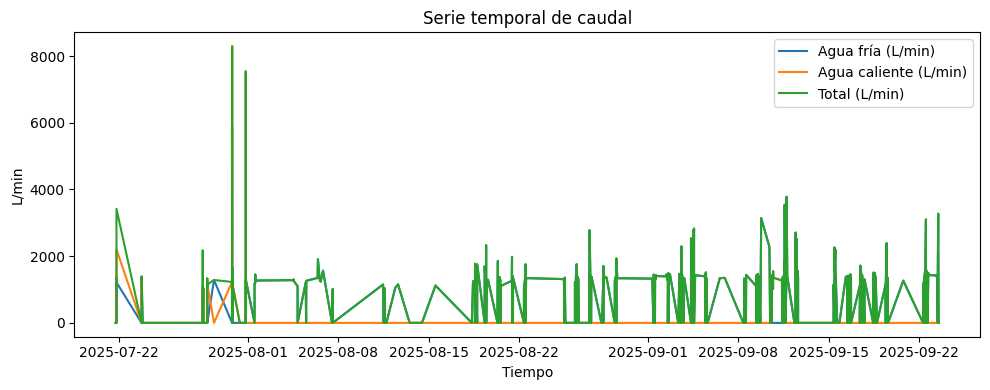

In [7]:
# 6.1 Serie temporal de caudal
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df['timestamp'], df['agua_fria'], label='Agua fría (L/min)')
ax.plot(df['timestamp'], df['agua_caliente'], label='Agua caliente (L/min)')
ax.plot(df['timestamp'], df['agua_total'], label='Total (L/min)')
ax.set_title('Serie temporal de caudal')
ax.set_xlabel('Tiempo')
ax.set_ylabel('L/min')
ax.legend()
fig.tight_layout()
fig.savefig(output_dir / 'fig_serie_caudales.png', dpi=200)
plt.show()


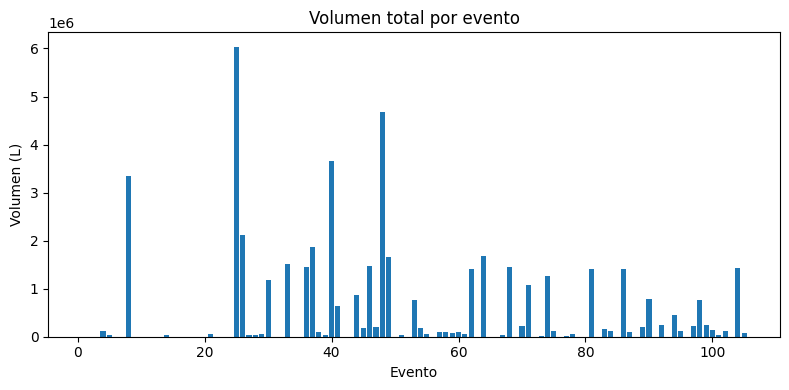

In [8]:
# 6.2 Volumen total por evento
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(eventos_df['ID'], eventos_df['Volumen_total_L'])
ax.set_title('Volumen total por evento')
ax.set_xlabel('Evento')
ax.set_ylabel('Volumen (L)')
fig.tight_layout()
fig.savefig(output_dir / 'fig_volumen_evento.png', dpi=200)
plt.show()


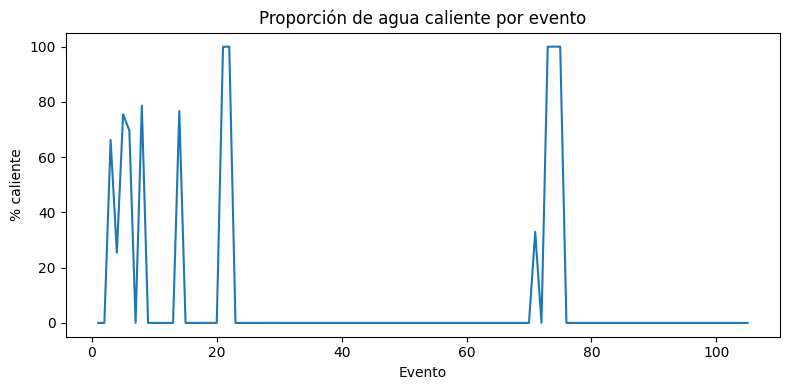

In [9]:
# 6.3 Proporción de agua caliente por evento
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(eventos_df['ID'], eventos_df['Proporcion_caliente_%'])
ax.set_title('Proporción de agua caliente por evento')
ax.set_xlabel('Evento')
ax.set_ylabel('% caliente')
fig.tight_layout()
fig.savefig(output_dir / 'fig_prop_caliente.png', dpi=200)
plt.show()
